In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [3]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
# Set the directories containing the images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [6]:
image_x = random.randint(0, 300)
image_x

114

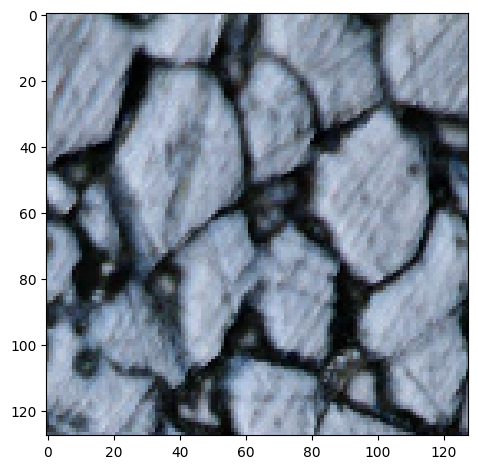

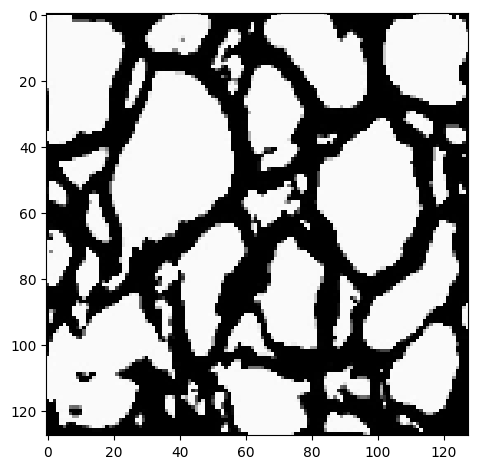

In [7]:
# example
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(IMG_CHANNELS, 1).to(device)

# print(model)

In [9]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Define the Few-Shot Grain Dataset
class FewShotGrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float().permute(2, 0, 1)
        mask = torch.from_numpy(self.masks[idx]).float().unsqueeze(0)  # Add channel dimension
        return image, mask

# Define a function to load a subset of images and masks for an episode
def load_subset(image_dir, mask_dir, subset_size):
    images = []
    masks = []
    # Get a list of image filenames
    image_files = sorted(os.listdir(image_dir))
    # Randomly select a subset of images
    selected_images = random.sample(image_files, subset_size)
    for image_file in selected_images:
        # Load image
        img_path = os.path.join(image_dir, image_file)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)
        # Load corresponding mask with the same format as the image
        mask_file = image_file.split('.')[0] + '_seg.jpg'
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path)
        if mask is None:
            print(f"Error: Failed to load mask: {mask_path}")
            continue
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        masks.append(mask)


    return images, masks

def episodic_train(model, optimizer, criterion, support_loader):
    model.train()
    for inputs, targets in support_loader:
        # Convert input data to cuda
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        # Remove the additional channel dimension from targets
        targets = targets.squeeze(3)

        # Convert targets to binary mask
        targets = targets.float()
        targets = (targets > 0.5)
        targets = targets.float()

        # Set the shape of the target tensor to [batch_size, height, width]
        targets = targets.view(-1, 3, targets.shape[2], targets.shape[3])

        # Move targets to the same device as outputs
        targets = targets.to(device)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Define the evaluation function
def evaluate(model, criterion, query_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in query_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            targets = targets.squeeze(3)
            targets = targets.to(device)
            # Convert targets to binary mask
            targets = targets.float()
            targets = (targets > 0.5)
            targets = targets.float()

            # Set the shape of the target tensor to [batch_size, height, width]
            targets = targets.view(-1, 3, targets.shape[2], targets.shape[3])
            # Remove extra channel dimension from outputs


            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(query_loader)
    return avg_loss

# Main Few-Shot Learning Training Loop
def few_shot_learning(train_dataset, val_dataset, num_episodes, num_support, num_query):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Split dataset into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create DataLoader for validation
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Initialize U-Net model
    model = UNet(in_channels=IMG_CHANNELS, out_channels=3).to(device)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    # Few-shot learning loop
    for episode in range(num_episodes):
        # Sample support and query sets for this episode
        support_indices = random.sample(range(len(train_dataset)), num_support)
        query_indices = random.sample(range(len(train_dataset)), num_query)
        support_set = torch.utils.data.Subset(train_dataset, support_indices)
        query_set = torch.utils.data.Subset(train_dataset, query_indices)

        # Create DataLoader for support and query sets
        support_loader = DataLoader(support_set, batch_size=1, shuffle=True)
        query_loader = DataLoader(query_set, batch_size=1, shuffle=False)

        # Perform episodic training
        episodic_train(model, optimizer, criterion, support_loader)

        # Evaluate on query set
        val_loss = evaluate(model, criterion, query_loader)
        print(f'Episode [{episode + 1}/{num_episodes}], Validation Loss: {val_loss:.4f}')

    # After training, evaluate on the validation set
    val_loss = evaluate(model, criterion, val_loader)
    print(f'Final Validation Loss: {val_loss:.4f}')

# Example usage
if __name__ == "__main__":
    # Set the directories containing the images and masks
    image_dir = '/content/data/Grains'
    mask_dir = '/content/data/Segmented'


    # Define hyperparameters
    num_episodes = 20  # Increase the number of episodes
    num_support = 30   # Keep the number of support samples per episode
    num_query = 30     # Keep the number of query samples per episode


    # Load images and masks
    images, masks = load_subset(image_dir, mask_dir, num_support + num_query)

    # Initialize FewShotGrainDataset
    few_shot_dataset = FewShotGrainDataset(images, masks)

    # Start few-shot learning
    few_shot_learning(few_shot_dataset, None, num_episodes, num_support, num_query)

Episode [1/20], Validation Loss: 0.6187
Episode [2/20], Validation Loss: 0.6121
Episode [3/20], Validation Loss: 0.6123
Episode [4/20], Validation Loss: 0.6142
Episode [5/20], Validation Loss: 0.6008
Episode [6/20], Validation Loss: 0.6038
Episode [7/20], Validation Loss: 0.6105
Episode [8/20], Validation Loss: 0.5953
Episode [9/20], Validation Loss: 0.5948
Episode [10/20], Validation Loss: 0.6052
Episode [11/20], Validation Loss: 0.6005
Episode [12/20], Validation Loss: 0.5994
Episode [13/20], Validation Loss: 0.6055
Episode [14/20], Validation Loss: 0.5860
Episode [15/20], Validation Loss: 0.6020
Episode [16/20], Validation Loss: 0.5911
Episode [17/20], Validation Loss: 0.5934
Episode [18/20], Validation Loss: 0.6010
Episode [19/20], Validation Loss: 0.5998
Episode [20/20], Validation Loss: 0.5996
Final Validation Loss: 0.5857


In [10]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

# Define the Few-Shot Grain Dataset
class FewShotGrainDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Define custom data augmentation transforms
class CustomTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
        ])

    def __call__(self, image, mask):
        # Apply the same transformation to both image and mask
        augmented = self.transform(image)
        augmented_mask = self.transform(mask)
        return augmented, augmented_mask

# Define a function to load a subset of images and masks for an episode
def load_subset(image_dir, mask_dir, subset_size):
    images = []
    masks = []
    # Get a list of image filenames
    image_files = sorted(os.listdir(image_dir))
    # Randomly select a subset of images
    selected_images = random.sample(image_files, subset_size)
    for image_file in selected_images:
        # Load image
        img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)
        # Load corresponding mask with the same format as the image
        mask_file = image_file.split('.')[0] + '_seg.jpg'
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path)
        if mask is None:
            print(f"Error: Failed to load mask: {mask_path}")
            continue
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        masks.append(mask)
    return images, masks

# Update the data loading process to use data augmentation
def load_data(image_dir, mask_dir, subset_size, transform):
    images, masks = load_subset(image_dir, mask_dir, subset_size)
    dataset = FewShotGrainDataset(images, masks, transform=transform)
    return dataset

def few_shot_learning(train_dataset, val_dataset, num_episodes, num_support, num_query):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Split dataset into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create DataLoader for validation
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # Initialize U-Net model
    model = UNet(in_channels=IMG_CHANNELS, out_channels=3).to(device)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    # Few-shot learning loop
    for episode in range(num_episodes):
        # Sample support and query sets for this episode
        support_indices = random.sample(range(len(train_dataset)), num_support)
        query_indices = random.sample(range(len(train_dataset)), num_query)
        support_set = torch.utils.data.Subset(train_dataset, support_indices)
        query_set = torch.utils.data.Subset(train_dataset, query_indices)

        # Create DataLoader for support and query sets
        support_loader = DataLoader(support_set, batch_size=1, shuffle=True)
        query_loader = DataLoader(query_set, batch_size=1, shuffle=False)

        # Perform episodic training
        episodic_train(model, optimizer, criterion, support_loader)

        # Evaluate on query set
        val_loss = evaluate(model, criterion, query_loader)
        print(f'Episode [{episode + 1}/{num_episodes}], Validation Loss: {val_loss:.4f}')

    # After training, evaluate on the validation set
    val_loss = evaluate(model, criterion, val_loader)
    print(f'Final Validation Loss: {val_loss:.4f}')

# Example usage
if __name__ == "__main__":
    # Set the directories containing the images and masks
    image_dir = '/content/data/Grains'
    mask_dir = '/content/data/Segmented'

    # Define hyperparameters
    num_episodes = 20
    num_support = 10
    num_query = 10

    # Load data with data augmentation
    transform = CustomTransform()
    train_dataset = load_data(image_dir, mask_dir, num_support + num_query, transform)

    # Start few-shot learning
    few_shot_learning(train_dataset, None, num_episodes, num_support, num_query)


Episode [1/20], Validation Loss: 0.6982
Episode [2/20], Validation Loss: 0.6964
Episode [3/20], Validation Loss: 0.6918
Episode [4/20], Validation Loss: 0.6872
Episode [5/20], Validation Loss: 0.6712
Episode [6/20], Validation Loss: 0.7039
Episode [7/20], Validation Loss: 0.6862
Episode [8/20], Validation Loss: 0.6926
Episode [9/20], Validation Loss: 0.6790
Episode [10/20], Validation Loss: 0.6625
Episode [11/20], Validation Loss: 0.6655
Episode [12/20], Validation Loss: 0.6715
Episode [13/20], Validation Loss: 0.6705
Episode [14/20], Validation Loss: 0.6760
Episode [15/20], Validation Loss: 0.6765
Episode [16/20], Validation Loss: 0.6714
Episode [17/20], Validation Loss: 0.6822
Episode [18/20], Validation Loss: 0.6744
Episode [19/20], Validation Loss: 0.6765
Episode [20/20], Validation Loss: 0.6499
Final Validation Loss: 0.6593


In [12]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [16]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and preprocess image
        img = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        img = cv2.resize(img, self.target_size)
        img = np.transpose(img, (2, 0, 1))  # Convert to channels-first format
        img = torch.tensor(img, dtype=torch.float32)

        # Load and preprocess mask
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]))
        mask = cv2.resize(mask, self.target_size)
        mask = np.any(mask > 245, axis=2)  # Convert to boolean mask
        mask = mask.astype(np.float32)
        mask = mask[np.newaxis, :, :]  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


In [17]:
from torch.utils.data import random_split

# Define directories for images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Create custom dataset
dataset = CustomDataset(image_dir, mask_dir)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [18]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Total Number samples: 68
Average Dice Score: 0.701700318385573
Average Jaccard Index: 0.5439044070594451
